In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

## 目的

外部プログラムadd_mul3.pyを動作させる。


cat add_mul3.py
```
#!/home/max/.virtualenvs/aiida/bin/python
import sys
import numpy as np

if __name__ == "__main__":
    inputfile = sys.argv[1]
    outputfile = "Outputfile.txt"
    print("inputfile",inputfile)
    with open(inputfile) as f:
        lines = f.readlines()
    nums =[]
    for line in lines:
        i = float(line)
        nums.append(i)
    nums = np.array(nums)
    print("nums",nums)
    i1 = nums[0]
    i2 = nums[1]
    i3 = nums[2]
    result = (i1+i2)*i3
    print("outputfile",outputfile)
    with open(outputfile,"w") as f:
        f.write(str(result))
    print("result",result)
    sys.exit(0)
```

In [2]:
!pwd

/home/kino/kino/kit/aiida_primer_v2.1/04.ExternalCalc


In [3]:
!diff externalcalc/pythoncalc/calculations/addmul.py externalcalc/pythoncalc/calculations/addmul3.py 

11a12,14
> 
>     _OUTPUT_PROG = "Outputfile.txt"
> 
18,19c21,24
<         spec.inputs['metadata']['options']['parser_name'].default = 'externalcalc.addmul'
<         spec.inputs['metadata']['options']['input_filename'].default = 'aiida.in'
---
>         spec.input("input_filename", valid_type=Str)
>         #spec.input('prog_output_filename', valid_type=Str, default=lambda: Str(cls._OUTPUT_PROG))
>         spec.input('metadata.options.prog_output_filename', valid_type=str, default=cls._OUTPUT_PROG)
>         spec.inputs['metadata']['options']['parser_name'].default = 'externalcalc.addmul2b'
39c44,47
<         with folder.open(self.options.input_filename, 'w', encoding='utf8') as handle:
---
>         # self.inputs.input_filename is Str
>         input_filename = self.inputs.input_filename.value
>         print("Input_filename",input_filename)
>         with folder.open(input_filename, 'w', encoding='utf8') as handle:
44c52
<         codeinfo.stdin_name = self.options.input_filename
--

# code setup
```sh
$  verdi code create core.code.installed 
Report: enter ? for help.
Report: enter ! to ignore the default and set no value.
Computer: tutor
Filepath executable: /home/kino/external_code/add_mul3.py
Label: externalcalc.addmul3
Description []: aiida primer addmul3
Default `CalcJob` plugin: externalcalc.addmul3
Escape using double quotes [y/N]: y
Success: Created InstalledCode<10708>

```

## daemon restart
AiiDA daemonのrestartと
```sh
$ verdi daemon restart 
```
Jupyter Python kernelのrestartを行う。

In [4]:
from aiida.engine import calcfunction,workfunction, WorkChain, ToContext, submit,run,while_
from aiida.orm import Str, Float, Int, Dict, load_node, load_code
import numpy as np
from aiida.plugins import DataFactory, CalculationFactory
import time

from aiida.common.datastructures import CalcInfo, CodeInfo
from aiida.common.folders import Folder
from aiida.engine import CalcJob, CalcJobProcessSpec

In [5]:
code = load_code("externalcalc.addmul3@tutor")
builder = code.get_builder()
builder.x = Int(1)
builder.y = Int(2)
builder.z = Int(4)
builder.input_filename = Str("Inputfile.txt")

result, workchain_node = run.get_node(builder)

12/05/2024 03:36:41 PM <9461> aiida.orm.nodes.process.calculation.calcjob.CalcJobNode: [REPORT] [12065|externalAddMulCalculation|prepare_for_submission]: values 1.2.4


Input_filename Inputfile.txt
calcinfo.retrieve_list ['aiida.out', 'Outputfile.txt']
parser: outputfilename Outputfile.txt


In [6]:
workchain_node

<CalcJobNode: uuid: 34322074-a4c9-480e-8d92-597ea21da2af (pk: 12065) (aiida.calculations:externalcalc.addmul3)>

In [7]:
workchain_node = submit(builder)
print(workchain_node.pk)

12069


In [16]:
from icecream import ic
ic(workchain_node.exception)
while not workchain_node.is_finished:
    ic(workchain_node.exception,workchain_node.is_finished)
    time.sleep(2)
ic(workchain_node.is_finished, workchain_node.is_finished_ok)
if workchain_node.is_finished_ok:
    ic(workchain_node.outputs.result)
else:
    raise

ic| workchain_node.exception: None
ic| workchain_node.is_finished: True
    workchain_node.is_finished_ok: True
ic| workchain_node.outputs.result: <Float: uuid: 6ed9ee2e-82c2-4499-b733-9f3983f874ad (pk: 10720) value: 12.0>


10717
Success: Output written to `10717.dot.pdf`


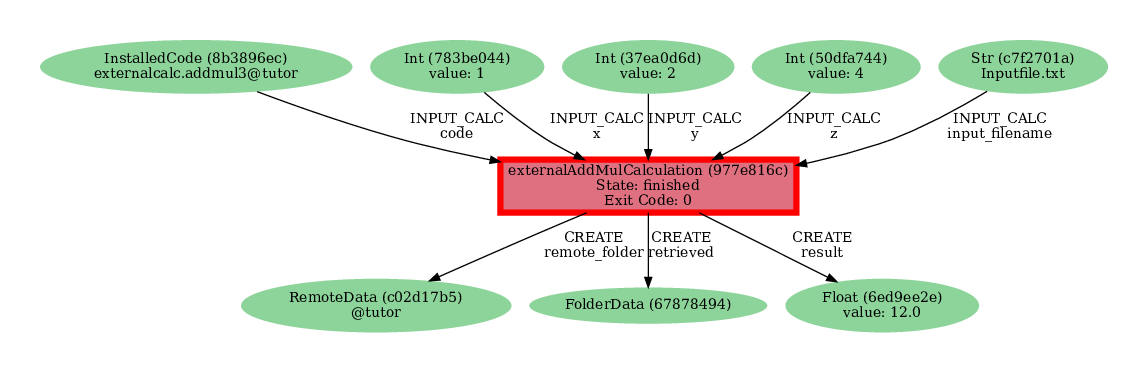

In [17]:
# This graph is big.
pk = workchain_node.pk
print(pk)
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

# 関連するverdi command

In [10]:
!verdi process report $pk

*** 10717: None
*** (empty scheduler output file)
*** Scheduler errors:
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
Traceback (most recent call last):
  File "/home/kino/miniconda3/envs/aiida/lib/python3.10/io.py", line 54, in <module>
ImportError: cannot import name 'text_encoding' from 'io' (unknown location)

*** 1 LOG MESSAGES:
+-> REPORT at 2024-12-04 22:06:19.396298+09:00
 | [10717|externalAddMulCalculation|prepare_for_submission]: values 1.2.4


## verdi calcjob

In [11]:
!verdi calcjob -h

Usage: verdi calcjob [OPTIONS] COMMAND [ARGS]...

  Inspect and manage calcjobs.

Options:
  -v, --verbosity [notset|debug|info|report|warning|error|critical]
                                  Set the verbosity of the output.
  -h, --help                      Show this message and exit.

Commands:
  cleanworkdir  Clean all content of all output remote folders of calcjobs.
  gotocomputer  Open a shell in the remote folder on the calcjob.
  inputcat      Show the contents of one of the calcjob input files.
  inputls       Show the list of the generated calcjob input files.
  outputcat     Show the contents of one of the calcjob retrieved outputs.
  outputls      Show the list of the retrieved calcjob output files.
  remotecat     Show the contents of a file in the remote working directory.
  res           Print data from the result output Dict node of a calcjob.


In [12]:
!verdi calcjob inputls $pk

.aiida
Inputfile.txt
_aiidasubmit.sh


In [13]:
!verdi calcjob inputcat $pk Inputfile.txt

1
2
4

In [14]:
!verdi calcjob outputls $pk

Outputfile.txt
_scheduler-stderr.txt
_scheduler-stdout.txt
aiida.out


In [15]:
!verdi calcjob outputcat $pk Outputfile.txt

12.0

以下でremote computerのdirectoryに直接loginできる。
```sh
$ verdi calcjob gotocomputer PK
```

```sh
$ ls
Inputfile.txt   _aiidasubmit.sh        _scheduler-stdout.txt
Outputfile.txt  _scheduler-stderr.txt  aiida.out
```